In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
from scipy import io, signal

## Spectral Signal Analysis

### Transforming Data

In [2]:
def generate_data() -> Tuple[np.ndarray, float, np.ndarray, np.ndarray]:
    """Generate sample data for the FFT-demo
    Signal is a  superposition of three sine waves.

    Returns
    -------
    t : time vector [s]
    dt : sample interval [s]
    sig_with_noise : signal vector, with random noise added
    sig_without_noise : signal vector
    """

    # First set the parameters
    rate = 200  # [Hz]
    duration = 60  # [sec]
    freqs = [3, 7, 20]
    amps = [1, 2, 3]

    # Then calculate the data
    dt = 1 / rate
    t = np.arange(0, duration, dt)

    # The clear way of doing it
    sig = np.zeros_like(t)
    for amp, freq in zip(amps, freqs):
        omega = 2 * np.pi * freq
        sig += amp * np.sin(omega * t)

    # Add some noise, and an offset
    np.random.seed(12345)
    offset = 1
    noise_amp = 5
    sig_without_noise = sig + offset
    sig_with_noise = sig_without_noise + noise_amp * np.random.randn(len(sig))

    return (t, dt, sig_with_noise, sig_without_noise)

In [3]:
def power_spectrum(
    t: np.ndarray, dt: float, sig: np.ndarray, sig_ideal: np.ndarray
) -> None:
    """Demonstrate three different ways to calculate the power-spectrum

    Parameters
    ----------
    t : time [sec]
    dt : sample period [sec]
    sig : sample signal to be analyzed
    sig_ideal : signal without noise
    """

    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    # From a quick look we learn - nothing
    axs[0].plot(t, sig, lw=0.7, label="noisy")
    axs[0].plot(t, sig_ideal, ls="dashed", lw=2, label="ideal")
    axs[0].set(xlim=(0, 0.4), ylim=(-15, 25), xlabel="Time (s)", ylabel="Signal ()")
    axs[0].legend()

    # Calculate the spectrum by hand
    fft_abs = np.abs(np.fft.fft(sig))
    # The easiest way to calculate the frequencies
    freq = np.fft.fftfreq(len(sig), dt)

    axs[1].plot(freq, fft_abs)
    axs[1].set(
        xlabel="Frequency (Hz)",
        ylabel="|FFT| ()",
        xlim=(0, 35),
        yticklabels=[],
    )

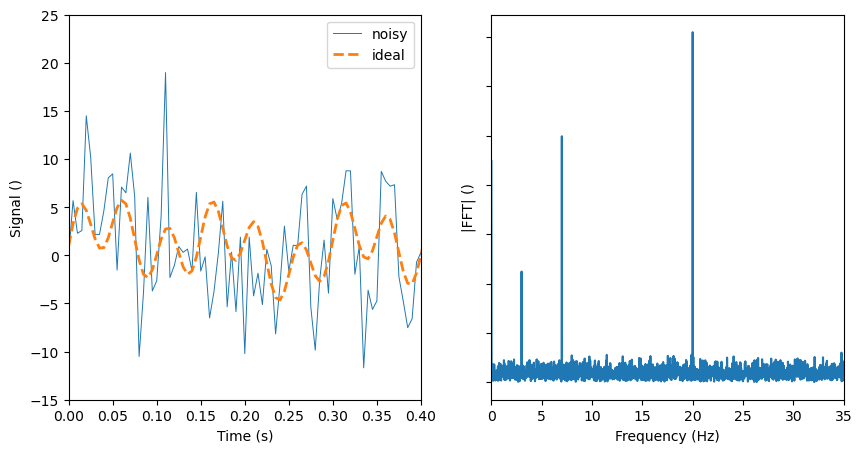

In [4]:
data = generate_data()
power_spectrum(*data)
# plt.savefig("../images/spectral-sample.png")
plt.show()

In [5]:
def power_spectrum2(
    t: np.ndarray, dt: float, sig: np.ndarray, sig_ideal: np.ndarray
) -> None:
    # Calculate the spectrum by hand
    fft_abs = np.abs(np.fft.fft(sig))
    # The easiest way to calculate the frequencies
    freq = np.fft.fftfreq(len(sig), dt)

    # With real input, the power spectrum is symmetrical and we only one half
    fft_abs = fft_abs[: int(len(fft_abs) / 2)]
    freq = freq[: int(len(freq) / 2)]
    # The power is the norm of the amplitude squared
    Pxx = fft_abs**2
    # Showing the same data on a linear and a log scale
    _, axs = plt.subplots(2, 1, sharex=True)
    axs[0].plot(freq, Pxx)
    axs[0].set(ylabel="Power (linear)")
    axs[1].semilogy(freq, Pxx)
    axs[1].set(xlabel="Frequency (Hz)", ylabel="Power (dB)")

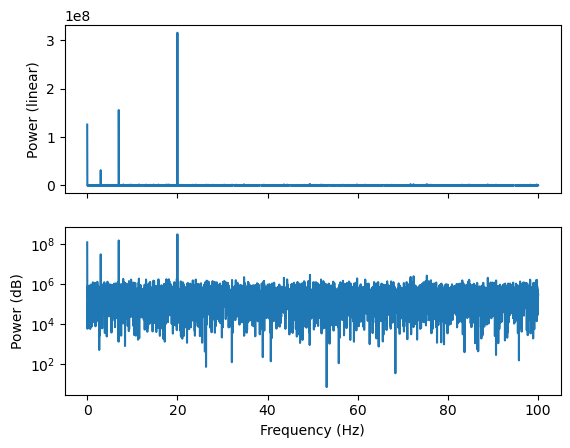

In [6]:
power_spectrum2(*data)
plt.show()

In [7]:
def power_spectrum3(
    t: np.ndarray, dt: float, sig: np.ndarray, sig_ideal: np.ndarray
) -> None:
    # Periodogram and Welch-Periodogram
    f_pgram, P_pgram = signal.periodogram(sig, fs=1 / dt)
    f_welch, P_welch = signal.welch(sig, fs=100, nperseg=2**8)

    _, axs = plt.subplots(2, 1, sharex=True)

    axs[0].semilogy(f_pgram, P_pgram, label="periodogram")
    axs[1].semilogy(f_welch, P_welch, label="welch")
    axs[0].set(ylabel="Spectral Density (dB)", ylim=(1e-4, 1e3))
    axs[0].legend()
    axs[1].set(xlabel="Frequency (Hz)", ylabel="Spectral Density (dB)")
    axs[1].legend()

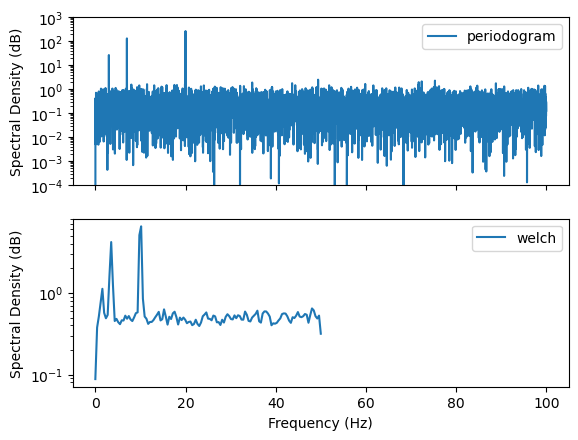

In [8]:
power_spectrum3(*data)
plt.show()

In [9]:
def get_data(in_file, sound_time, time_slice):
    """Get the required data"""

    # Get the data
    sound_rate, sound_data = io.wavfile.read(in_file)

    # Select the time when the tone is clear
    a1 = sound_data[sound_time]
    a1_range = a1.max() - a1.min()
    a1 = a1 / a1_range
    time = np.arange(len(a1)) / sound_rate

    # Calculate the power-spectrum by hand
    a1_fft = np.fft.fft(a1)
    Pxx = np.abs(a1_fft) ** 2

    dt = 1 / sound_rate
    duration = dt * len(a1)
    freq = np.arange(len(a1)) / duration

    # Normalize to 'density'
    Pxx = Pxx * 2 / (np.sum(Pxx) / duration)

    return time, a1, sound_rate, freq, Pxx, duration

In [10]:
# Specify the parameters
sound_time = range(7000, 20000)
time_slice = [0.175, 0.185]

(time, sound_data, rate, freq, Pxx, duration) = get_data(
    "../data/a1.wav", sound_time, time_slice
)

In [11]:
def fourier_intro(time, data, freq, Pxx, time_slice):
    """Time- and frequency presentation of sound."""

    _, axs = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True)
    axs[0].plot(time, data, lw=0.5)
    axs[0].set(xlabel="Time (s)", ylabel="Sound-pressure")
    axs[0].margins(x=0)

    axs[1].plot(time, data)
    axs[1].set(xlim=time_slice, xlabel="Time (s)", yticklabels=[])

    axs[2].plot(freq, np.sqrt(Pxx))
    axs[2].set(xlim=[0, 4000], xlabel="Frequency (Hz)", ylabel="|FFT|")
    axs[2].ticklabel_format(style="sci", scilimits=(0, 4))

    # Position the plots
    axs[0].set(position=[0.125, 0.11, 0.2, 0.775])
    axs[1].set(position=[0.35, 0.11, 0.2, 0.775])

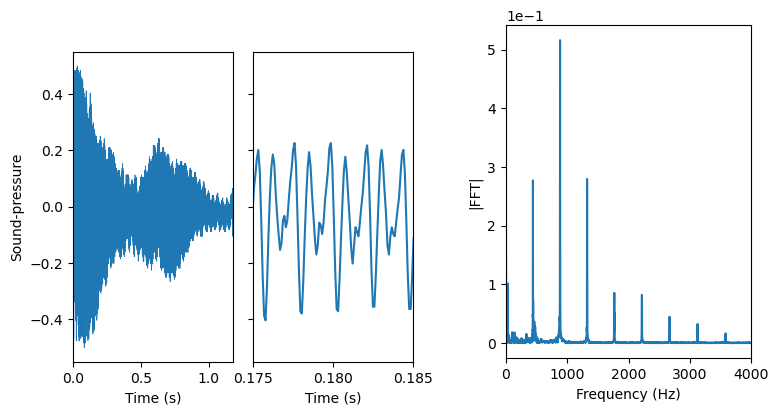

In [12]:
fourier_intro(time, sound_data, freq, Pxx, time_slice)
# plt.savefig("../images/spectral-sound.png")
plt.show()

## Spectral Density Estimation

### Periodogram

In [13]:
def linear_and_log(freq, Pxx):
    """Comparison of linear and log representatino of powerspectrum."""

    _, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
    upper_limit = 4000
    axs[0].plot(freq, Pxx)
    axs[0].set(
        xlim=[0, upper_limit],
        xlabel="Frequency (Hz)",
        ylabel="Power spectrum",
    )
    axs[0].ticklabel_format(style="sci", scilimits=(0, 4))

    axs[1].semilogy(freq, Pxx, lw=0.5)
    axs[1].set(
        xlim=[0, upper_limit],
        xlabel="Frequency (Hz)",
        ylabel="Power spectrum (dB)",
    )

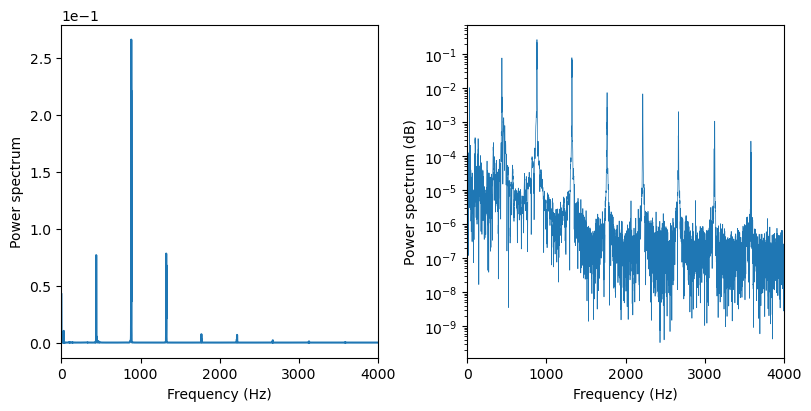

In [14]:
linear_and_log(freq, Pxx)
# plt.savefig("../images/spectral-periodo.png")
plt.show()

In [15]:
def noise_effects(time, sound, Pxx, time_slice, duration):
    """Effect of adding noise to a signal on the powerspectrum"""

    # Note that a1 has been normalized to have a range of 1
    sound_noisy = sound + 1 / 100 * np.random.randn(len(sound))
    fft_noisy = np.fft.fft(sound_noisy)
    Pxx_noisy = np.abs(fft_noisy) ** 2

    # Normalize to 'density'
    Pxx_noisy = Pxx_noisy * 2 / (np.sum(Pxx_noisy) / duration)

    _, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
    axs[0].plot(time, sound, label="original")
    axs[0].plot(time, sound_noisy, label="noise added")
    axs[0].set(xlabel="Time (s)", ylabel="Sound-pressure ()", xlim=time_slice)
    axs[0].legend()

    axs[1].semilogy(freq, Pxx, label="original", lw=0.5)
    axs[1].semilogy(freq, Pxx_noisy, label="noise added", lw=0.5)
    axs[1].set(
        xlim=[1200, 1700],
        xlabel="Frequency (Hz)",
        ylabel="Power spectrum (P**2/Hz)",
    )

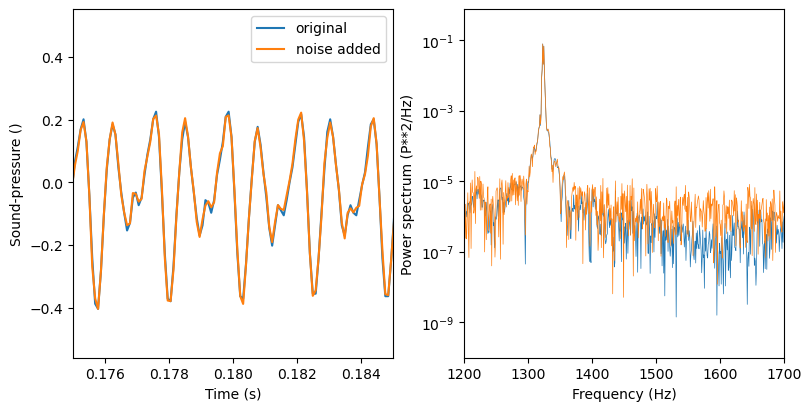

In [16]:
noise_effects(time, sound_data, Pxx, time_slice, duration)
# plt.savefig("../images/spectral-periodo-noise.png")
plt.show()

## Fourier Transformation, Convolution, and Cross-Correlation

In [17]:
def welch_periodogram(data, rate, freq, Pxx):
    """Comparison of simple powerspectrum to Welch-periodogram"""

    _, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
    f, welch = signal.welch(data, fs=rate, nperseg=len(data) / 8)
    df = np.diff(f)[0]
    # "normalize" welch
    welch = welch / (np.sum(welch) * df)

    axs[0].semilogy(freq, Pxx, label="Periodogram", lw=0.5)
    axs[0].semilogy(f, welch, label="Welch", lw=0.8)
    axs[0].set(
        xlim=[0, rate / 2],
        xlabel="Frequency (Hz)",
        ylabel="Powerspectrum (P**2/Hz)",
    )

    axs[1].semilogy(freq, Pxx, label="Pxx")
    axs[1].semilogy(f, welch, label="Welch")
    axs[1].set(xlim=[800, 1100], xlabel="Frequency (Hz)")
    axs[1].legend()

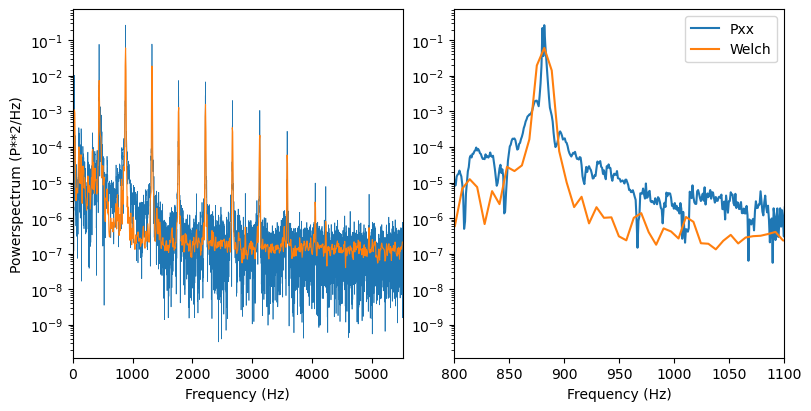

In [18]:
welch_periodogram(sound_data, rate, freq, Pxx)
# plt.savefig("../images/spectral-periodo-welch.png")
plt.show()

## Time Dependent Fourier Transform

### Windowing

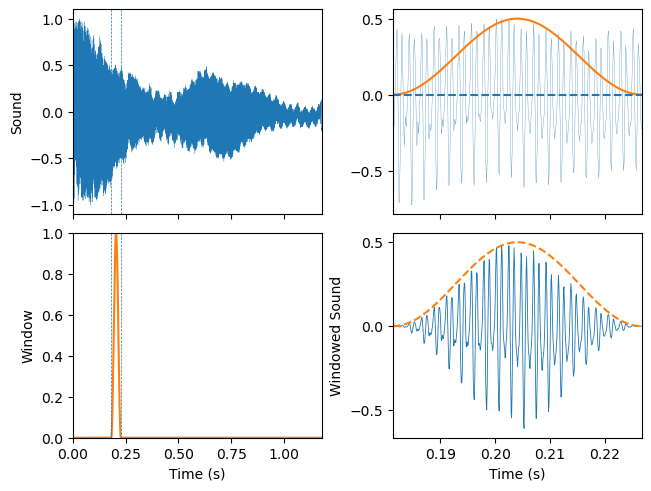

In [19]:
# Set the parameters
slice = range(7000, 20000)

win_length = 500
win_index = range(2000, 2000 + win_length)


# Get the data
rate_w, sound = io.wavfile.read("../data/a1.wav")
a1 = np.float32(sound[slice])
time_w = np.arange(len(a1)) / rate_w

a1 /= np.max(a1)
max_sound = np.max(a1[win_index])

# Make the plots
fig, ax_w = plt.subplots(2, 2, constrained_layout=True)
# Sound
ax_w[0, 0].plot(time_w, a1, lw=0.2)
ax_w[0, 0].margins(x=0)
ax_w[0, 0].set(ylabel="Sound")
ax_w[0, 0].set(xticklabels="")

# Window
window = np.zeros_like(time_w)
window[win_index] = signal.windows.hann(win_length)
ax_w[1, 0].plot(time_w, window, color="C1")
ax_w[1, 0].set(xlabel="Time (s)", ylabel="Window", ylim=(0, 1))
for ax in [ax_w[0, 0], ax_w[1, 0]]:
    for index in [min(win_index), max(win_index)]:
        ax.axvline(time_w[index], lw=0.5, ls="dashed")

# Sound & window
ax_w[0, 1].plot(time_w[win_index], a1[win_index], lw=0.2)
ax_w[0, 1].plot(time_w[win_index], window[win_index] * max_sound)
ax_w[0, 1].set_xticklabels("")
ax_w[0, 1].set_yticks([-0.5, 0, 0.5])
ax_w[0, 1].axhline(0, ls="dashed")

# Windowed sound
ax_w[1, 1].plot(time[win_index], window[win_index] * a1[win_index], lw=0.6)
ax_w[1, 1].plot(time[win_index], window[win_index] * max_sound, ls="dashed")
ax_w[1, 1].set(xlabel="Time (s)", ylabel="Windowed Sound", yticks=[-0.5, 0, 0.5])

for ax in ax_w.ravel():
    ax.margins(x=0)

# plt.savefig("../images/spectral-window.png")
plt.show()

In [20]:
def powerSpect(data: np.ndarray, rate: float) -> Tuple:
    """Powerspectrum, calculated via Fourier Transfrom

    Parameters
    ----------
    data : signal
    rate : sampling rate [Hz]

    Returns
    -------
    Pxx : one-sided power spectrum
    freq : corresponding frequencies [Hz]
    """

    n_data = len(data)
    fft_coeffs = fft.fft(data)

    Pxx = np.abs(fft_coeffs) ** 2 / n_data
    freq = fft.fftfreq(n_data, 1 / rate)

    nyq = int(len(Pxx) / 2)
    return (Pxx[:nyq], freq[:nyq])

In [21]:
def showData(data: np.ndarray, rate: float, legend: str, axs) -> None:
    """Show data in time domain, and corresponding powerspectrum

    Parameters
    ----------
    data : signal
    rate : sample rate [Hz]
    legend : type of signal
    axs : axes in which to plot the signal and the powerspectrum
    """

    t = np.arange(len(data)) / rate
    axs[0].plot(t, data, label=legend)

    # Calculate the powerspectrum
    (Pxx, freq) = powerSpect(data, rate)

    axs[1].plot(freq, Pxx, ".-", lw=0.5)
    axs[1].set(xlim=(1, 5000))

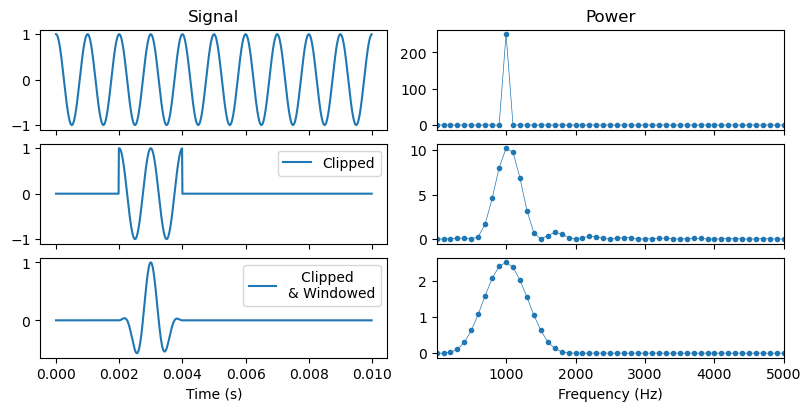

In [22]:
# Set the parameters
sample_rate = 100000
dt_h = 1.0 / sample_rate
f_h = 1000
tMax = 0.01

_, ax_h = plt.subplots(3, 2, figsize=(8, 4), constrained_layout=True)

# Data ...
t_h = np.arange(0, tMax, dt_h)
x_h = np.cos(2 * np.pi * f_h * t_h)

# ... clipped ...
y_h = x_h.copy()
y_h[:199] = 0
y_h[400:1001] = 0

# ... and windowed
z_h = y_h.copy()
hann = signal.windows.hann(201)
z_h[199:400] = z_h[199:400] * hann

# Plot the data
showData(x_h, sample_rate, "Cosine wave", ax_h[0])
showData(y_h, sample_rate, "Clipped", ax_h[1])
showData(z_h, sample_rate, "   Clipped\n& Windowed", ax_h[2])

# Format the plot
ax_h[0, 0].set(title="Signal")
ax_h[0, 1].set(title="Power")

ax_h[1, 0].legend()
ax_h[2, 0].legend()
for axh in ax_h[0].tolist() + ax_h[1].tolist():
    axh.set(xticklabels="")

ax_h[2, 0].set(xlabel="Time (s)")
ax_h[2, 1].set(xlabel="Frequency (Hz)")
# plt.savefig("../images/spectral-hann.png")
plt.show()